In [42]:
# Library Imports.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Allows plots to appear directly in the notebook.
%matplotlib inline

from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

- temp temperature(c)
- dwpt dew point temperature
- rhum relative humidity
- prcp precipitation
- snow snowfall
- wdir wind direction
- wspd wind speed
- wpgt max wind gust(m/s)
- pres atmospheric pressure
- tsun sunshine duration
- coco weather condition
(1	Clear
2	Fair
3	Cloudy
4	Overcast
5	Fog
6	Freezing Fog
7	Light Rain
8	Rain
9	Heavy Rain
10	Freezing Rain
11	Heavy Freezing Rain
12	Sleet
13	Heavy Sleet
14	Light Snowfall
15	Snowfall
16	Heavy Snowfall
17	Rain Shower
18	Heavy Rain Shower
19	Sleet Shower
20	Heavy Sleet Shower
21	Snow Shower
22	Heavy Snow Shower
23	Lightning
24	Hail
25	Thunderstorm
26	Heavy Thunderstorm
27	Storm)

In [43]:
# combined 4 month files
df_uc = pd.read_csv('nyc_weather_4months.csv', keep_default_na=True, sep=',',skipinitialspace=True)
df_uc.head(5)

,datetime,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
0,2024-02-01 00:00:00,3.9,-1.7,67.0,0.0,280.0,5.4,1018.5,3.0
1,2024-02-01 01:00:00,3.3,-1.7,70.0,0.0,270.0,5.4,1018.4,3.0
2,2024-02-01 02:00:00,4.0,-1.0,70.0,0.0,240.0,6.0,1019.0,3.0
3,2024-02-01 03:00:00,3.9,-0.5,73.0,0.0,260.0,9.4,1018.4,3.0
4,2024-02-01 04:00:00,4.0,-0.4,73.0,0.0,237.0,10.1,1019.0,2.0


In [44]:
df2 = df_uc.copy()
df2.dtypes

datetime     object
temp        float64
dwpt        float64
rhum        float64
prcp        float64
wdir        float64
wspd        float64
pres        float64
coco        float64
dtype: object

In [45]:

# Check missing values
missing_summary = df2.isnull().sum()
print("Missing values per column:")
print(missing_summary)

# Convert 'time' to datetime
df2['time'] = pd.to_datetime(df2['datetime'])

# Convert 'coco' to category
df2['coco'] = df2['coco'].astype('category')

# Fill or drop NaNs based on your strategy:

numeric_cols = df2.select_dtypes(include=['float64']).columns

df2[numeric_cols] = df2[numeric_cols].fillna(0)

print("\n Filled NaNs in numeric columns with 0.")

final_check = df2.isnull().sum()
print("\nFinal missing value check:")
print(final_check)

Missing values per column:
datetime       0
temp           0
dwpt        5157
rhum        5157
prcp           0
wdir        5157
wspd        5157
pres        5157
coco           0
dtype: int64

 Filled NaNs in numeric columns with 0.

Final missing value check:
datetime    0
temp        0
dwpt        0
rhum        0
prcp        0
wdir        0
wspd        0
pres        0
coco        0
time        0
dtype: int64


In [46]:
if 'Unknown' not in df2['coco'].cat.categories:
    df2['coco'] = df2['coco'].cat.add_categories(['Unknown'])

df2['coco'] = df2['coco'].fillna('Unknown')

In [47]:
df2.dtypes

datetime            object
temp               float64
dwpt               float64
rhum               float64
prcp               float64
wdir               float64
wspd               float64
pres               float64
coco              category
time        datetime64[ns]
dtype: object

In [48]:
# remove duplicate columns/columns with no analytical significance.
duplicate_rows = df2.duplicated().sum()
print(f"Duplicate rows: {duplicate_rows}" )

df2 = df2.drop_duplicates()

Duplicate rows: 0


### Descriptive Table (numeric)

In [49]:
from IPython.display import display
numeric_columns = df2.select_dtypes(include=['float64']).columns
interval_columns = df2.select_dtypes(include=['datetime64[ns]']).columns

print("1. Show continuous features:")
print("Numeric Columns:", numeric_columns)
print("Datetime Columns:", interval_columns)

print("2. Descriptive statistics table - continuous features")

numeric_sum = df2[numeric_columns].describe().T

interval_sum = df2[interval_columns].describe().T

table_continuous = pd.concat([numeric_sum, interval_sum])

# display(table_continuous)

con_columns = list(numeric_columns) + list(interval_columns)
df_table_continuous = df2[con_columns].describe(include="all").T

display(df_table_continuous)

1. Show continuous features:
Numeric Columns: Index(['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres'], dtype='object')
Datetime Columns: Index(['time'], dtype='object')
2. Descriptive statistics table - continuous features


,count,mean,min,25%,50%,75%,max,std
temp,8041.0,12.956672,-10.6,3.3,17.8,22.8,33.9,9.183721
dwpt,8041.0,1.795834,-19.5,0.0,0.0,0.0,24.5,7.011189
rhum,8041.0,22.025743,0.0,0.0,0.0,50.0,100.0,31.406486
prcp,8041.0,0.032533,0.0,0.0,0.0,0.0,10.8,0.303383
wdir,8041.0,58.357543,0.0,0.0,0.0,60.0,360.0,106.074547
wspd,8041.0,3.322497,0.0,0.0,0.0,6.0,46.4,5.741033
pres,8041.0,365.111255,0.0,0.0,0.0,1014.0,1049.0,488.289054
time,8041,2024-07-17 12:00:00,2024-02-01 00:00:00,2024-04-24 18:00:00,2024-07-17 12:00:00,2024-10-09 06:00:00,2025-01-01 00:00:00,NaN


In [50]:
#drop column which is all 0
columns_to_drop = ['snow', 'wpgt', 'tsun']
# df2 = df2.drop(columns=columns_to_drop)

print(f"Dropped columns: {columns_to_drop}")
print(f"Remaining columns: {df2.columns.tolist()}")

Dropped columns: ['snow', 'wpgt', 'tsun']
Remaining columns: ['datetime', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'pres', 'coco', 'time']


In [51]:
#remaining columns and types
df2.dtypes

datetime            object
temp               float64
dwpt               float64
rhum               float64
prcp               float64
wdir               float64
wspd               float64
pres               float64
coco              category
time        datetime64[ns]
dtype: object

### Descriptive Table (categorical)

In [52]:
print("1. Descriptive statistics table - categorical features")
cat_columns = df2.select_dtypes(include=["category", "object"]).columns
df_table_categ = df2[cat_columns].describe(include="all").T
display(df_table_categ)

1. Descriptive statistics table - categorical features


,count,unique,top,freq
datetime,8041,8041,2025-01-01 00:00:00,1
coco,8041.0,18.0,-1.0,5163.0


In [53]:
#missing data
# Prepare %missing column
category_columns_perc_missing  = 100 * (df2[cat_columns].isnull().sum()/df2.shape[0])
#category_columns_perc_missing

# Store the values in a dataframe
df_category_perc_missing = pd.DataFrame(category_columns_perc_missing, columns=['%missing'])
df_category_perc_missing

,%missing
datetime,0.0
coco,0.0


In [54]:
# Count occurrences of each coco code
coco_counts = df2['coco'].value_counts(dropna=False).sort_index()

print("Occurrence count for each coco code:")
print(coco_counts)

Occurrence count for each coco code:
coco
-1.0        5163
 1.0         975
 2.0         275
 3.0        1254
 4.0          30
 5.0          97
 7.0          65
 8.0          64
 9.0          52
 12.0         13
 13.0          6
 14.0          6
 15.0         15
 16.0          7
 17.0         11
 18.0          6
 19.0          1
 20.0          1
 Unknown       0
Name: count, dtype: int64


In [55]:
#group coco
# Mapping dictionary
coco_group_map = {
    1.0: 'Clear/Fair',
    2.0: 'Clear/Fair',
    3.0: 'Cloudy/Overcast',
    5.0: 'Fog/Low-Vis',
    7.0: 'Rain',
    8.0: 'Rain',
    9.0: 'Heavy Rain',
    12.0: 'Snow/Sleet',
    13.0: 'Heavy Snow/Sleet',
    14.0: 'Snow/Sleet',
    15.0: 'Snow/Sleet',
    16.0: 'Heavy Snow/Sleet',
    17.0: 'Rain',
    18.0: 'Heavy Rain',
    21.0: 'Snow/Sleet',
    'Unknown': 'Unknown'
}

# Apply mapping
df2['coco_group'] = df2['coco'].map(coco_group_map)

# Check result
print("Simplified coco grouping done. Group counts:")
print(df2['coco_group'].value_counts())

Simplified coco grouping done. Group counts:
coco_group
Cloudy/Overcast     1254
Clear/Fair          1250
Rain                 140
Fog/Low-Vis           97
Heavy Rain            58
Snow/Sleet            34
Heavy Snow/Sleet      13
Name: count, dtype: int64


In [56]:
#for backend
#using openweather API
# def map_weather_to_coco_group(weather_id):
#     if weather_id == 800:
#         return 'Clear/Fair'
#     elif 801 <= weather_id <= 804:
#         return 'Cloudy/Overcast'
#     elif 200 <= weather_id <= 232:
#         return 'Thunderstorm'
#     elif (300 <= weather_id <= 321) or (500 <= weather_id <= 531):
#         return 'Rain'
#     elif 600 <= weather_id <= 622:
#         return 'Snow/Sleet'
#     elif 701 <= weather_id <= 781:
#         return 'Fog/Low-Vis'
#     else:
#         return 'Unknown'


In [57]:
df2.isna().sum().sort_values(ascending=False)

coco_group    5195
temp             0
datetime         0
dwpt             0
rhum             0
wdir             0
prcp             0
wspd             0
pres             0
coco             0
time             0
dtype: int64

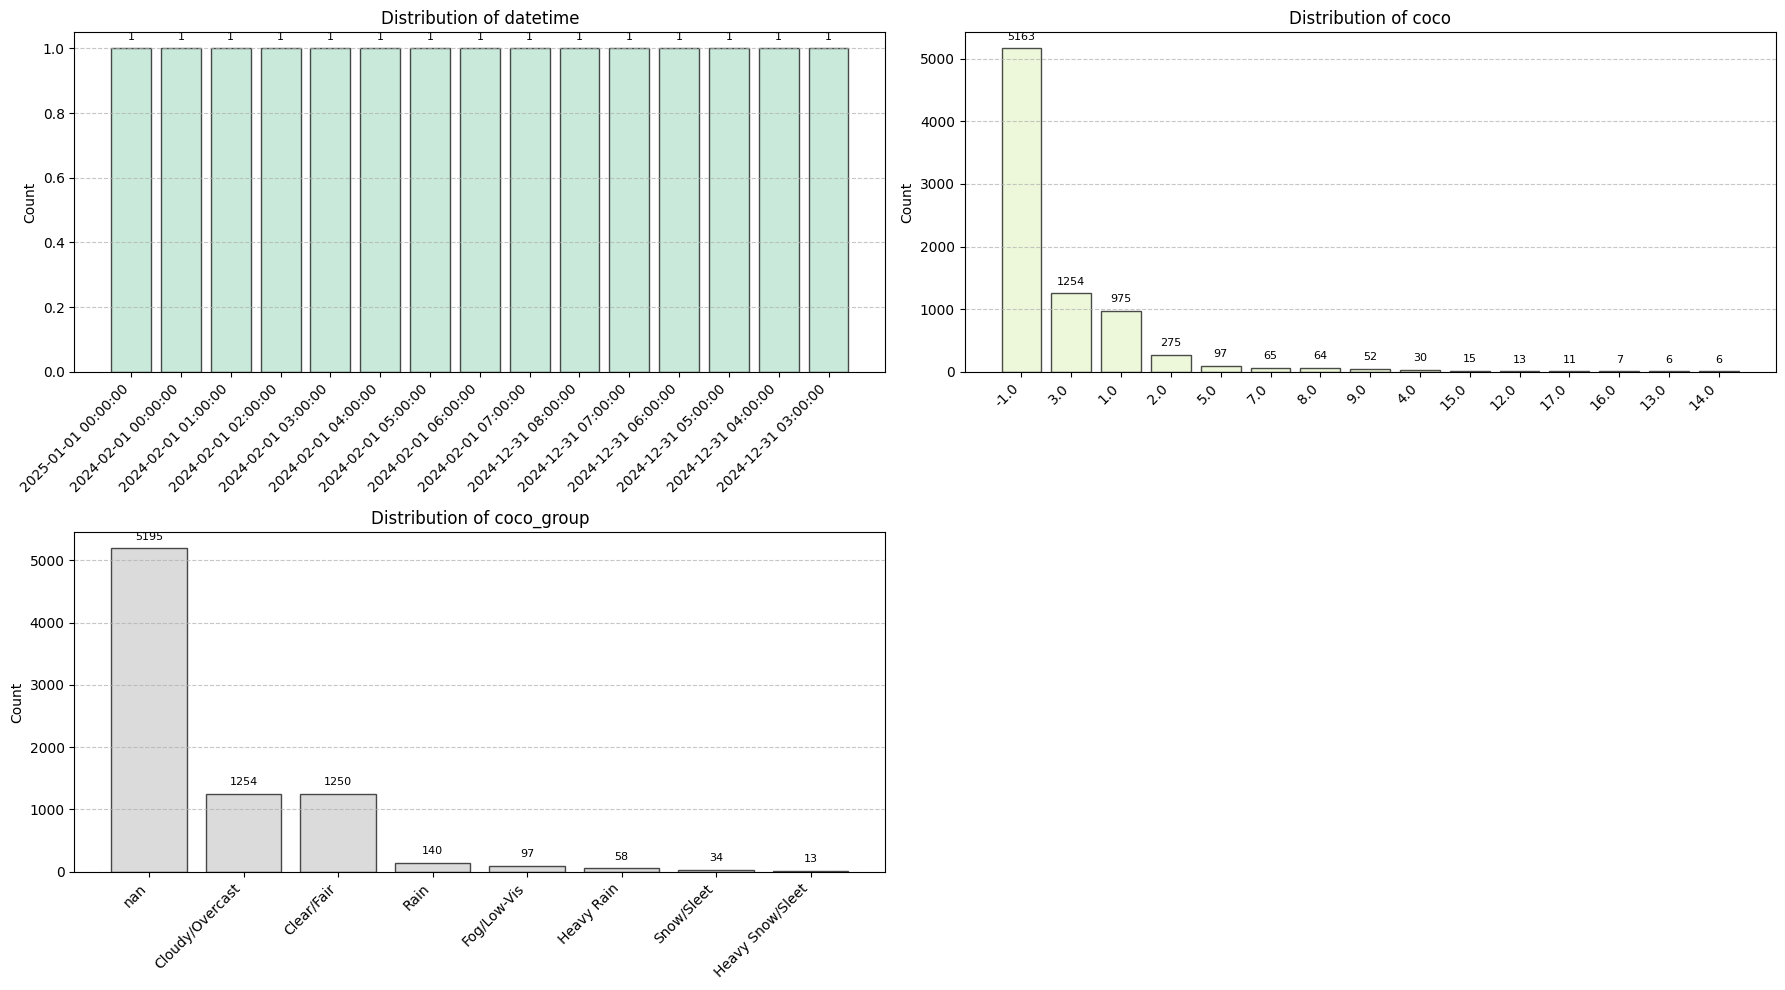

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

categorical_column = df2.select_dtypes(include=['object', 'category']).columns
n_features = len(categorical_column)
n_rows = (n_features + 1) // 2  

fig, axes = plt.subplots(n_rows, 2, figsize=(18, 5 * n_rows))
axes = axes.ravel()


colors = plt.cm.Pastel2(np.linspace(0, 1, min(n_features, 8)))


with PdfPages('categorical_barplots.pdf') as pp:
    for idx, column in enumerate(categorical_column):
        if idx >= len(axes):
            break

        value_counts = df2[column].value_counts(dropna=False)[:15]

        axes[idx].bar(value_counts.index.astype(str),
                    value_counts.values,
                    color=colors[idx % len(colors)], alpha=0.7, edgecolor='black')

        axes[idx].set_xticks(range(len(value_counts.index)))
        axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=10)
        axes[idx].set_title(f'Distribution of {column}', fontsize=12)
        axes[idx].set_ylabel('Count', fontsize=10)
        axes[idx].grid(True, linestyle='--', alpha=0.7, axis='y')


        for i, v in enumerate(value_counts.values):
            axes[idx].text(i, v + max(value_counts.values) * 0.02, str(v), ha='center', va='bottom', fontsize=8)


    for idx in range(n_features, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    pp.savefig(fig)
    plt.show()

In [59]:
# Save the cleaned (non-one-hot) dataframe
cleaned_file_path = 'cleaned_data_weather_4months.csv'
df2.to_csv(cleaned_file_path, index=False)
print(f" Saved cleaned data to {cleaned_file_path}")

 Saved cleaned data to cleaned_data_weather_4months.csv


In [60]:
df2.tail(20)

,datetime,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco,time,coco_group
8021,2024-12-31 05:00:00,8.9,-0.7,51.0,0.0,254.0,5.4,1011.0,1.0,2024-12-31 05:00:00,Clear/Fair
8022,2024-12-31 06:00:00,8.0,-0.7,54.0,0.0,250.0,6.0,1012.0,1.0,2024-12-31 06:00:00,Clear/Fair
8023,2024-12-31 07:00:00,7.8,-1.2,53.0,0.0,251.0,7.6,1011.5,1.0,2024-12-31 07:00:00,Clear/Fair
8024,2024-12-31 08:00:00,7.8,-1.2,53.0,0.0,254.0,7.6,1012.1,1.0,2024-12-31 08:00:00,Clear/Fair
8025,2024-12-31 09:00:00,7.2,-0.5,58.0,0.0,246.0,5.4,1012.3,1.0,2024-12-31 09:00:00,Clear/Fair
8026,2024-12-31 10:00:00,7.0,-0.7,58.0,0.0,256.0,9.0,1014.0,1.0,2024-12-31 10:00:00,Clear/Fair
8027,2024-12-31 11:00:00,7.8,-0.7,55.0,0.0,250.0,7.6,1013.0,2.0,2024-12-31 11:00:00,Clear/Fair
8028,2024-12-31 12:00:00,8.0,-1.0,53.0,0.0,259.0,6.0,1014.0,2.0,2024-12-31 12:00:00,Clear/Fair
8029,2024-12-31 13:00:00,8.9,-1.0,50.0,0.0,280.0,5.4,1013.5,1.0,2024-12-31 13:00:00,Clear/Fair
8030,2024-12-31 14:00:00,10.0,-1.7,44.0,0.0,0.0,0.0,1013.4,1.0,2024-12-31 14:00:00,Clear/Fair


In [61]:
mapping_df = pd.DataFrame.from_dict(coco_group_map, orient='index', columns=['coco_group']).reset_index()
mapping_df.columns = ['coco', 'coco_group']
mapping_df.to_csv('coco_group_mapping_cleaned.csv', index=False)

In [62]:
df2['date'] = df2['time'].dt.date
hour_counts = df2.groupby('date').size()
incomplete_days = hour_counts[hour_counts < 24]
print(incomplete_days)

date
2025-01-01    1
dtype: int64
